In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')


# Matthew Chan
# Assignment 3
# May 19, 2022

# 1 Feed-forward Neural Network for Binary Classification (70 Points)

You are given a real-world dataset to predict the prognosis of Breast Cancer patients using genetic biomarkers. We have randomly sampled this dataset as two subsets: the Labeled Data (BRCA- prognosis-train.csv, n = 1404) and the Unlabeled Data (BRCA-prognosis-test.csv, n = 500). Parts a through d below require you to work with the Labeled Data, while part e asks you to make predictions on the Unlabeled Data and submit your predictions. Your task is to predict the breast cancer prognostic status, whose variable name is "outcome". A value of 1 is worse prognosis and a value of 0 is better prognosis. The codebook of this dataset is provided in hw3_codebook.xlsx.

a. (12 points) Data preprocessing and exploratory data analysis.

• Perform exploratory data analysis on any variables of the Labeled Data using at least two of the following:

– Histogram or density plots

– Box plots or bar plots

– Line plots or curves

– Summary tables

– Statistical tests

• You may perform any data transformation, feature selection, and/or feature engineering, as you wish.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving five-cancers-gene-expression.csv to five-cancers-gene-expression.csv
Saving BRCA-prognosis-test.csv to BRCA-prognosis-test.csv
Saving BRCA-prognosis-train.csv to BRCA-prognosis-train.csv


In [3]:
labelled_all = pd.read_csv('BRCA-prognosis-train.csv')
labelled_all.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut,outcome
0,0.6522,-1.0002,0.2878,0.4661,-1.1925,1.2016,-0.7379,-0.5657,0.5885,1.0009,...,0,0,0,0,0,0,0,0,0,0
1,-1.1329,2.7485,-0.7175,0.9446,-0.2574,-1.2881,-0.9623,-0.4673,0.2962,-0.9181,...,0,0,0,0,0,0,0,0,0,1
2,-0.6247,0.9146,-0.0536,-0.0933,0.0326,-1.7125,-1.0493,-0.6886,-0.5311,-1.7056,...,0,0,0,0,0,0,0,0,0,0
3,0.5877,-2.2261,2.4252,-0.6472,-1.7071,0.8207,-0.4278,3.4991,-0.5951,-1.0470,...,0,0,0,0,0,0,0,0,0,0
4,-0.2048,-1.2539,-1.7408,0.2214,-0.0545,0.9722,0.8895,0.9785,-0.3633,-1.1611,...,0,0,0,0,0,0,0,0,0,1


In [4]:
labelled_all.isnull().sum().sum() #check if there are any missing values

0

In [5]:
labelled_all.dtypes # look at data types for each column

brca1          float64
brca2          float64
palb2          float64
pten           float64
tp53           float64
                ...   
prps2_mut       object
smarcb1_mut     object
stmn2_mut        int64
siah1_mut       object
outcome          int64
Length: 663, dtype: object

In [6]:
labelled_all = labelled_all.select_dtypes(exclude=['object']) # I removed features that were string since neural networks don't take strings as inputs
labelled_all.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,stmn2_mut,outcome
0,0.6522,-1.0002,0.2878,0.4661,-1.1925,1.2016,-0.7379,-0.5657,0.5885,1.0009,...,-0.3340,-1.1800,-0.4451,1.6071,0.6102,-0.2418,0.1797,-0.9129,0,0
1,-1.1329,2.7485,-0.7175,0.9446,-0.2574,-1.2881,-0.9623,-0.4673,0.2962,-0.9181,...,-0.3996,-0.4933,0.1318,-0.9725,-1.2502,-0.8092,-0.4028,-0.3039,0,1
2,-0.6247,0.9146,-0.0536,-0.0933,0.0326,-1.7125,-1.0493,-0.6886,-0.5311,-1.7056,...,-0.0975,0.0660,0.6925,-1.1984,-0.4592,-0.5628,-0.2193,2.5006,0,0
3,0.5877,-2.2261,2.4252,-0.6472,-1.7071,0.8207,-0.4278,3.4991,-0.5951,-1.0470,...,-0.3499,-0.3053,0.4242,-0.0827,0.6007,-0.9394,0.2227,-0.5339,0,0
4,-0.2048,-1.2539,-1.7408,0.2214,-0.0545,0.9722,0.8895,0.9785,-0.3633,-1.1611,...,-0.4912,0.2716,-1.3303,-0.5253,-0.8740,0.2546,-0.1168,1.2691,0,1


In [7]:
print(labelled_all.describe()) # display summary statistics

             brca1        brca2        palb2         pten         tp53  \
count  1404.000000  1404.000000  1404.000000  1404.000000  1404.000000   
mean      0.000090    -0.033844     0.024035    -0.011157     0.011936   
std       0.989816     0.999775     0.994332     1.008835     0.988798   
min      -2.335600    -2.708900    -3.742000    -5.932800    -2.481200   
25%      -0.723200    -0.721100    -0.656775    -0.575600    -0.649175   
50%      -0.130150    -0.110750     0.004550     0.094550    -0.004450   
75%       0.549875     0.590750     0.661600     0.638850     0.655075   
max       4.554200     3.737900     4.615000     2.630700     4.149200   

               atm         cdh1        chek2          nbn          nf1  ...  \
count  1404.000000  1404.000000  1404.000000  1404.000000  1404.000000  ...   
mean      0.025500     0.014164     0.008059     0.011962    -0.006756  ...   
std       0.985012     0.988141     0.981519     1.003056     0.976198  ...   
min      -3.17050

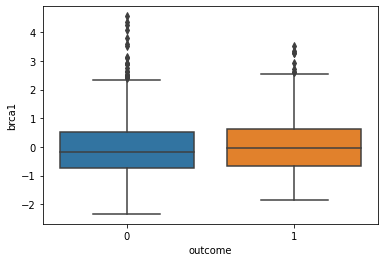

In [8]:
 
sns.boxplot(x="outcome", y="brca1", data=labelled_all) # Display a boxplot of BRCA1 cancer grouped by outcome. 
# BRCA cancer outcome 1 shows a slightly higher mean but group outcome 0 has more outliers than group outcome 1.
 

In [9]:
labelled_all.groupby("outcome").mean() # Shows the mean for all columns grouped by outcome

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,stmn2_mut
outcome,,,,,,,,,,,,,,,,,,,,,
0,-0.029239,-0.018144,0.013332,0.082962,0.027125,0.004036,-0.026443,-0.064370,0.001970,0.041433,...,0.016322,-0.058388,0.003187,-0.001699,0.073712,0.056743,0.030640,0.022301,0.030792,0.0
1,0.063504,-0.067791,0.047177,-0.214659,-0.020903,0.071909,0.101962,0.164663,0.033565,-0.110948,...,-0.020789,0.113209,-0.021565,-0.017666,-0.102111,-0.103698,-0.020005,-0.063438,-0.073162,0.0


In [10]:
test_data = pd.read_csv('BRCA-prognosis-test.csv')
test_data.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-0.6113,-0.4112,-0.5326,1.2881,-1.3982,-0.2587,0.3170,-0.1585,-0.9302,-0.2004,...,0,0,0,G12S,0,0,0,0,0,0
1,-0.7632,0.6394,1.0946,-0.7267,-1.1607,1.2332,-0.6189,0.3389,3.3672,1.7262,...,0,0,0,0,0,0,0,0,0,0
2,-0.4674,-0.4817,1.0418,0.6514,0.5839,-0.1902,-0.1550,-1.1869,-0.6927,1.4632,...,0,0,0,0,0,0,0,0,0,0
3,1.2946,0.7721,-0.9238,0.3801,-0.3273,-1.1697,0.7206,1.8837,-1.4707,-0.6701,...,0,0,0,0,0,0,0,0,0,0
4,-1.0671,-0.2272,0.5382,-1.4913,2.7068,-0.8004,-0.7550,1.9918,-0.2418,-0.9464,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_data = test_data.select_dtypes(exclude=['object']) # I exclude the columns with strings datatype since neural network can't handle strings
test_data.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,mtap_mut,smarcb1_mut,siah1_mut
0,-0.6113,-0.4112,-0.5326,1.2881,-1.3982,-0.2587,0.3170,-0.1585,-0.9302,-0.2004,...,-0.2375,1.0650,-1.2506,0.3477,-0.4917,-0.9829,-0.8620,0,0,0
1,-0.7632,0.6394,1.0946,-0.7267,-1.1607,1.2332,-0.6189,0.3389,3.3672,1.7262,...,0.0995,-0.1606,0.1523,1.0216,-0.4922,-0.2179,-0.6845,0,0,0
2,-0.4674,-0.4817,1.0418,0.6514,0.5839,-0.1902,-0.1550,-1.1869,-0.6927,1.4632,...,-0.3238,-0.0529,-0.1678,0.7934,0.7468,0.6742,0.8129,0,0,0
3,1.2946,0.7721,-0.9238,0.3801,-0.3273,-1.1697,0.7206,1.8837,-1.4707,-0.6701,...,-1.2429,-0.8571,0.1682,-0.6899,-0.0781,0.2424,-0.5679,0,0,0
4,-1.0671,-0.2272,0.5382,-1.4913,2.7068,-0.8004,-0.7550,1.9918,-0.2418,-0.9464,...,-0.6006,1.4273,0.2951,1.1445,-0.9995,-0.3719,-0.3240,0,0,0


In [12]:
labelled_all.outcome.value_counts() # Display the counts for the classes (0 and 1)

0    960
1    444
Name: outcome, dtype: int64

b. (6 points) Propose a deep learning-based model development and evaluation plan. You may answer this question in paragraph format, flow-chart, or pseudocode. Your proposed model must include the following elements:

• Architecture of the feed-forward neural network.

• Validation method. You may split the** Labeled Data** into a Training Portion and a Validation Portion with any reasonable ratio. You may also use cross-validation instead of this plain train/validation splitting method.

• Hyperparamers to optimize (e.g. learning rate).

You may also include in the proposal any other techniques you are going to use, such as early stopping and learning rate decay.

The input of the feed forward network consists of 490 features . There are 500 hidden nodes with the RELU intermediate activation function going into output node with the sigmoid activation function to compute probabilities of whether  you have the outcome. The binary cross entropy function is used as the loss function for training because the class variable takes on a binary value. ADAM  which is a part of the torch package is used as the optimizer function to improve accuracy. The data is split into 70% training and 30% validation. 

The hyperparameters that are optimized are the learning rate, number of hidden nodes, and the number of features. I tried using PCA to reduce the number of features but it didn't make that much of a difference in improving accuracy. I also experimented with the number of hidden nodes but it did not make a huge diffence in accuarcy score. I experimented with different activation functions such as tanh and but accuracy score and auc were much lower than expected. I experimented with different rates and found that a very high learning rate (0.1) causes the validation loss to explode. The learning rate will be set as 0.0001 (after tuning) so the validation loss won't explode. If the learning rate too low, this will increase the possibility of overfitting so the optimal learning rate to be 0.0001.  

In [13]:
!pip install pytorch-lightning

     |████████████████████████████████| 584 kB 28.0 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
     |████████████████████████████████| 136 kB 59.2 MB/s 
     |████████████████████████████████| 409 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 144 kB 63.2 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 49.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import TQDMProgressBar

from tqdm import tqdm

%matplotlib inline

In [15]:
labelled_all['cancer'] = labelled_all.outcome.astype('category').cat.codes
labelled_all

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,stmn2_mut,outcome,cancer
0,0.6522,-1.0002,0.2878,0.4661,-1.1925,1.2016,-0.7379,-0.5657,0.5885,1.0009,...,-1.1800,-0.4451,1.6071,0.6102,-0.2418,0.1797,-0.9129,0,0,0
1,-1.1329,2.7485,-0.7175,0.9446,-0.2574,-1.2881,-0.9623,-0.4673,0.2962,-0.9181,...,-0.4933,0.1318,-0.9725,-1.2502,-0.8092,-0.4028,-0.3039,0,1,1
2,-0.6247,0.9146,-0.0536,-0.0933,0.0326,-1.7125,-1.0493,-0.6886,-0.5311,-1.7056,...,0.0660,0.6925,-1.1984,-0.4592,-0.5628,-0.2193,2.5006,0,0,0
3,0.5877,-2.2261,2.4252,-0.6472,-1.7071,0.8207,-0.4278,3.4991,-0.5951,-1.0470,...,-0.3053,0.4242,-0.0827,0.6007,-0.9394,0.2227,-0.5339,0,0,0
4,-0.2048,-1.2539,-1.7408,0.2214,-0.0545,0.9722,0.8895,0.9785,-0.3633,-1.1611,...,0.2716,-1.3303,-0.5253,-0.8740,0.2546,-0.1168,1.2691,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,-0.8468,0.4818,0.6131,0.0600,-0.6060,1.7714,0.8917,0.1010,-0.8821,-0.7944,...,-0.1574,0.0609,-0.7515,-0.7533,-0.3382,-0.9709,-0.7446,0,1,1
1400,-0.1844,0.0005,0.3751,-0.7222,-1.8560,0.7996,0.1025,0.7319,2.6620,-0.0314,...,0.4442,-1.1431,0.9517,0.9265,-0.6195,0.6319,-0.9378,0,0,0
1401,1.4376,-0.3174,1.3291,0.4604,0.7625,-0.3105,-2.8114,0.1046,0.7327,0.1248,...,0.3992,0.2071,1.1053,0.9165,1.4470,5.2869,0.4819,0,0,0
1402,-1.2448,-2.2417,0.5508,0.8508,-0.6159,1.5829,0.0555,1.3599,-0.5648,-0.5968,...,-0.0895,0.3770,-0.6747,-0.8193,-0.7135,0.1929,0.0175,0,1,1


In [16]:
labelled_all.drop(labels=['outcome'],axis=1,inplace=True)

In [17]:
lab_train, lab_val = train_test_split(labelled_all, test_size=0.3, random_state=50, stratify=labelled_all.cancer)

In [18]:
X_train = lab_train.drop(labels=['cancer'],axis=1)
y_train = lab_train['cancer']
X_val = lab_val.drop(labels=['cancer'],axis=1)
y_val = lab_val['cancer']
 

In [19]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-0.037229,1.060969,1.520971,-0.086144,-1.796135,-0.161865,-0.841861,0.818367,-1.018452,0.524811,...,0.372497,-0.587683,0.768663,-0.451846,1.275075,1.616364,-0.163428,0.556445,2.072724,0.0
1,0.395627,-0.925488,0.404403,-0.359913,1.251048,-0.176316,1.050265,-0.258713,0.355246,0.068005,...,-0.874500,-0.546156,1.433244,-0.962254,-0.117610,-0.280159,-0.431846,-0.348057,0.250367,0.0
2,0.393719,0.168053,-0.292159,-0.075026,2.303266,-0.225430,-1.202382,0.320818,-0.729869,0.184349,...,1.069306,1.762046,-0.997334,0.998379,-1.011450,0.086881,-0.384569,-0.620593,-0.830751,0.0
3,0.481676,-1.008001,-1.092329,0.526837,-0.231022,1.473428,1.441542,-0.837031,0.320933,2.476944,...,-1.392954,-0.816520,-1.013371,-0.218235,0.643364,-0.217710,-0.267419,-0.278995,-0.898889,0.0
4,-1.188501,0.141914,1.622044,-0.696687,-1.120102,1.044848,0.389207,-0.628388,-0.868904,-1.347318,...,1.631629,-0.813784,-0.055583,0.305362,0.875978,-0.052711,-0.357255,0.201451,-0.176326,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.892400,0.853711,-0.254143,-0.225126,-1.368214,-1.113210,0.313029,0.719100,0.299314,-0.682807,...,-0.319340,-0.346046,0.343327,-0.490440,0.084489,1.289733,-0.562243,0.643519,-0.146548,0.0
978,-0.764581,1.044095,-2.340181,-0.174214,-1.280089,-1.309562,0.735572,-0.172789,0.723364,-0.675271,...,-0.993370,1.779145,0.593667,1.327643,-1.115101,0.025146,-0.028403,-0.243152,1.246188,0.0
979,1.877340,0.163859,-0.180239,-0.956216,2.477687,1.091334,0.430250,2.382990,0.065571,-0.411718,...,0.050701,1.211548,0.383672,-1.500214,-1.629954,-0.448933,-0.219144,0.003226,-0.801376,0.0
980,0.100329,-0.792453,0.565390,-1.653268,-1.913432,-0.596205,1.790861,0.713136,-0.254846,-0.904552,...,-1.649794,-0.753986,1.171305,-0.400161,-0.838965,0.023718,-0.210524,-0.269944,-0.630578,0.0


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca

,0,1,2,3,4,5,6,7,8,9
0,10.754771,2.479058,-2.330728,-4.701958,-5.914544,0.497508,-4.229748,-0.562210,1.850295,-3.658794
1,-1.023406,-1.634895,3.729211,-6.239972,-3.675777,2.916738,-2.375186,0.132672,-2.644324,0.406324
2,1.549908,10.116889,-3.123144,1.155583,5.553332,-8.097039,5.230474,1.578117,-3.734123,-0.015140
3,3.931373,-3.291663,-0.186683,-2.886868,1.358352,-3.017245,-2.932442,7.433147,1.604239,1.142009
4,-4.339512,-5.237872,3.835166,-4.747418,-0.299211,1.276500,-0.014842,1.220482,0.644485,2.233983
...,...,...,...,...,...,...,...,...,...,...
977,-2.016283,1.306328,-1.377454,-4.486899,-2.803010,-0.018715,-0.529482,2.049537,4.285072,2.776200
978,-7.271141,6.595855,-4.601090,1.859393,-6.426225,2.152604,3.761971,-2.895698,0.282804,3.555203
979,-0.943758,16.849844,4.645714,0.879409,0.515199,4.092117,1.348287,-4.322466,-0.367329,1.747060
980,0.747520,2.871404,6.980099,-6.538157,-1.530756,3.527733,-0.491842,1.623539,-0.778398,-0.361977


In [21]:
# Variance explained by each component 

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.0777491 , 0.06673683, 0.05537956, 0.03762658, 0.02620003,
       0.02220475, 0.02061646, 0.01701965, 0.01624018, 0.01427517])

In [22]:
X_val = StandardScaler().fit_transform(X_val)
X_val = pd.DataFrame(X_val)
X_val

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,0.420690,-0.100255,-0.735122,-0.181954,-0.160285,-0.811075,-0.892295,-0.393948,-0.267316,0.948549,...,-0.643011,-0.062698,-0.611710,-0.299463,0.551647,-0.390656,-0.766213,-1.492795,-0.391306,0.0
1,-1.686661,-0.541398,1.299996,0.973274,1.195506,-1.778637,0.905059,0.320529,2.392400,0.883400,...,0.622562,-0.395815,-0.445799,0.980017,-0.738740,-1.309096,-0.455752,-0.061069,-0.955648,0.0
2,1.053224,-0.836881,1.484997,0.219323,-1.182552,0.191116,-2.045766,1.040826,0.725023,0.911177,...,-0.196647,-0.962051,0.223349,-1.901130,-0.763563,-0.744623,-0.354867,0.341762,-0.962967,0.0
3,0.946552,1.834748,0.216386,-1.242977,0.328749,1.529528,1.398246,3.243708,-0.182203,0.929055,...,0.752060,-0.213118,-1.691802,0.393220,-0.960824,0.519994,3.398351,-0.291203,1.926615,0.0
4,0.042566,0.190315,-0.933076,-2.016204,-1.467838,0.787930,0.919559,-0.077973,0.873313,-1.119964,...,1.184245,0.969669,1.226678,-0.214207,-0.201181,0.225679,2.564009,0.185084,2.160513,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,-0.243363,-0.311162,-0.686276,-0.519185,0.057994,-0.463139,0.245276,0.828998,-1.416941,-0.816540,...,-0.215132,-0.323242,-0.669798,-1.170975,-0.068317,-0.466281,-0.098146,-0.092718,-0.668715,0.0
418,1.691404,1.284148,-0.336048,-1.384440,0.276879,0.392828,-0.523805,2.058908,-1.294428,-1.336118,...,-1.559160,-1.870158,1.825746,5.892376,-0.762241,-0.468746,0.325618,0.705001,-0.191095,0.0
419,-0.201166,-0.385594,1.888125,-1.201316,2.043494,-1.038991,-0.722300,-0.390726,2.348833,1.887910,...,1.011791,-0.773130,0.208704,0.531420,2.303293,1.187403,-0.758520,-1.141799,-0.907425,0.0
420,0.294101,-0.941961,0.803032,-1.340498,0.968852,-0.901091,1.093254,-0.112273,0.450884,-1.919734,...,0.889225,1.110806,0.459438,-0.884576,0.157023,-1.535181,-0.606202,0.031140,-0.649867,0.0


In [23]:
test_data = StandardScaler().fit_transform(test_data)
test_data = pd.DataFrame(test_data)
test_data = test_data.iloc[:, 0:490]

test_data

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-0.593819,-0.508523,-0.458835,1.288835,-1.323635,-0.180155,0.345542,-0.129308,-0.904194,-0.206044,...,0.155836,0.363162,-0.250220,1.052797,-1.186237,0.355238,-0.530484,-1.044984,-0.850768,0.0
1,-0.741437,0.546830,1.146407,-0.777364,-1.093279,1.256405,-0.560915,0.344071,3.429553,1.603553,...,-0.902672,0.219093,0.086364,-0.180700,0.200863,1.011902,-0.531072,-0.242695,-0.676761,0.0
2,-0.453975,-0.579342,1.094319,0.635892,0.598843,-0.114196,-0.111609,-1.108044,-0.664685,1.356525,...,-0.561965,-0.135608,-0.336413,-0.072306,-0.115632,0.789539,0.927459,0.692888,0.791172,0.0
3,1.258354,0.680130,-0.844756,0.357671,-0.284948,-1.057363,0.736445,1.814269,-1.449266,-0.647219,...,-0.102564,0.997267,-1.254378,-0.881687,0.216584,-0.655825,-0.043600,0.240041,-0.562456,0.0
4,-1.036770,-0.323691,0.597515,-1.561470,2.657886,-0.701761,-0.692734,1.917148,-0.209972,-0.906739,...,-0.476642,0.169196,-0.612871,1.417432,0.342055,1.131659,-1.128258,-0.404202,-0.323355,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.107914,-1.071760,-1.289176,0.581233,0.123001,-0.599308,0.219729,0.145164,1.638532,-1.408497,...,1.046423,-0.482679,2.492686,1.850806,-2.102501,-0.817190,-0.385808,-0.603568,-0.316297,0.0
496,0.976043,-1.400440,-0.267847,-1.048714,0.974784,-1.761633,0.068443,-0.764002,0.143896,0.639111,...,-0.217171,1.745823,-0.323929,-0.368603,0.730134,-0.268784,-0.794173,-0.572840,-0.608531,0.0
497,-1.114320,0.352555,0.350692,-1.042971,-0.581840,-0.893091,0.240552,1.337654,-0.150674,0.049061,...,-0.025706,1.890796,-0.243229,0.261230,-0.897921,0.461450,-0.707650,0.774795,-0.622843,0.0
498,-0.719280,-0.797926,-1.013054,-1.269712,-0.861759,1.577053,0.898967,-0.076012,-1.607795,-0.899977,...,-0.103440,1.070757,0.893865,-0.320193,-1.288572,-1.120528,1.112630,-0.482858,2.955328,0.0


In [24]:
print(f"number of features = {X_train.shape[1]}")
print(f"number of classes = {y_train.unique().shape[0]}")

number of features = 490
number of classes = 2


In [25]:
print(f"number of features = {X_val.shape[1]}")
print(f"number of classes = {y_val.unique().shape[0]}")

number of features = 490
number of classes = 2


c. **(14 points)** Implement the feed-forward neural network model that you proposed in part b using the **Training Portion of the Labeled Data** that you have split. Tune hyperparameters and monitor the model performance (including loss and AUC) in the validation dataset.
You may use any established, popular Python libraries to complete this task, including Tensorflow, Keras, or PyTorch (preferred). However, you CANNOT use external software, models, or datasets to train the model (transfer learning or fine-tuning is also unacceptable). And you CANNOT use the MLPClassifier from sklearn, as it is not flexible enough for neural network models. We have provided a demo that implements a simple Neural Network model that you can use as your starter code.

In [26]:
# I used the code from the demo provided in class and modified some hyperparameters such as the learning rate, loss function, activation function,
# and number of hidden nodes to improve accuracy

class Logger:
    def __init__(self):
        self.log = {}
    def add(self, key, value):
        if key in self.log.keys():
            self._add_valid(key, value)
        else:
            self.log[key] = {}
            self.log[key]['history'] = []
            self.log[key]['last_epoch'] = 0 if key.split('_')[0] == 'train' else -1
            self._add_valid(key, value)
            
    def _add_valid(self, key, value):
        epoch = self.log[key]['last_epoch'] + 1
        self.log[key]['history'].append({'epoch':epoch, key:value})
        self.log[key]['last_epoch'] = epoch
            
    def get(self, key):
        if key is None:
            return self.log
        return self.log[key]['history']

In [71]:
class FlexFC(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(490, 500), 
            nn.ReLU(),
            nn.Linear(500,1),
            nn.Sigmoid())
  
        self.writer = Logger()
        #self.train_f1 = torchmetrics.F1Score()
        #self.validation_f1 = torchmetrics.F1Score()
        self.train_auc = torchmetrics.AUC(reorder=True)
        self.validation_auc=torchmetrics.AUC(reorder=True)

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.fc(x)
       # x = F.tanh(x)
        #x = F.log_softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        h = self.fc(x)
        #loss = F.cross_entropy(h, y.long())
        loss = F.binary_cross_entropy(h, y.long().unsqueeze(1).float())
        self.train_auc(h, y.int())
        #self.train_f1(h, y.int())
        # default logger
        self.log("train_loss", loss)
        return loss

    def training_epoch_end(self, training_step_outputs):
        res = []
        for out in training_step_outputs:
            res.append(out['loss'].item())
        # customized logger
        #self.writer.add('train_f1', self.train_f1.compute().item())
        self.writer.add('train_auc', self.train_auc.compute().item())
        self.writer.add('train_loss', sum(res)/len(res))
        self.train_auc.reset()
        #self.train_f1.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        h = self.fc(x)
        #loss = F.cross_entropy(h, y.long())
        loss = F.binary_cross_entropy(h, y.long().unsqueeze(1).float())
        #self.validation_f1(h,y.int())
        self.validation_auc(h,y.int())
        # default logger
        self.log("val_loss", loss)
        return loss
    
    def validation_epoch_end(self, validation_step_outputs):
        res = []
        for out in validation_step_outputs:
            res.append(out.item())
        # customized logger
        #self.writer.add('val_f1', self.validation_f1.compute().item())
        self.writer.add('val_auc', self.validation_auc.compute().item())
        self.writer.add('val_loss', sum(res)/len(res))
        self.validation_auc.reset()
       # self.validation_f1.reset()

    def configure_optimizers(self):
        # define your optimizers here
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
     #   optimizer = torch.optim.SGD(self.parameters(),lr=0.001,
                                 #momentum=0.8,weight_decay=0.01, nesterov=True)
        return optimizer

# disable the validation progress bar (optional)
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

In [72]:
# define our dataset loader
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        super().__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, idx):
        xi = torch.tensor(self.X.iloc[idx].to_numpy()).float()
        if self.y is None:
            return xi
        yi = torch.tensor(self.y.iloc[idx].item()).float()
        return xi, yi


# prepare the dataset
tt = PandasDataset(X_train,y_train)
train_loader = DataLoader(tt, batch_size=100, shuffle=True, num_workers=4)

vv = PandasDataset(X_val,y_val)
val_loader = DataLoader(vv, batch_size=100, shuffle=False, num_workers=4)


In [73]:
# initiate the model
model = FlexFC()
# train the model for 10 epochs
bar = LitProgressBar()
#trainer = pl.Trainer(
 #   accelerator="gpu", devices=1,
  #  max_epochs=50, 
   # callbacks=[bar])
# or if you do not have gpu
trainer = pl.Trainer(
     max_epochs=10, 
     callbacks=[bar])
res = trainer.fit(
    model=model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | fc             | Sequential | 246 K 
1 | train_auc      | AUC        | 0     
2 | validation_auc | AUC        | 0     
----------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.984     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

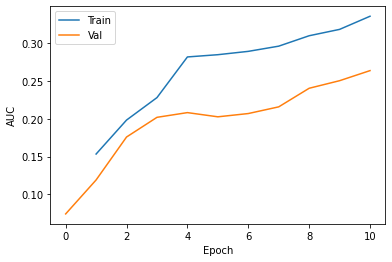

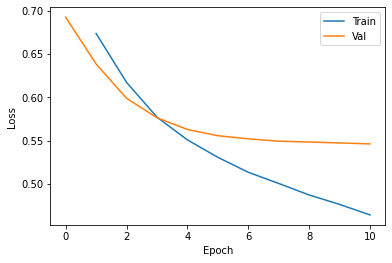

In [74]:
history_dict = model.writer.log

# convert it to pandas DF
dtlog = pd.concat([pd.DataFrame(x['history']).set_index('epoch') for x in history_dict.values()], axis=1)

# plot the F1 score
sns.lineplot(x=dtlog.index, y=dtlog.train_auc, label='Train')
sns.lineplot(x=dtlog.index, y=dtlog.val_auc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show()

# plot the loss curve
sns.lineplot(x=dtlog.index, y=dtlog.train_loss, label='Train')
sns.lineplot(x=dtlog.index, y=dtlog.val_loss, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [75]:
vv = PandasDataset(X_val)
val_loader_pred = DataLoader(vv, batch_size=64, shuffle=False, num_workers=4)

In [76]:
trainer.predict(model, dataloaders=val_loader_pred)

Predicting: 10it [00:00, ?it/s]

[tensor([[0.4753],
         [0.5221],
         [0.4627],
         [0.3674],
         [0.2690],
         [0.1418],
         [0.5120],
         [0.4675],
         [0.4442],
         [0.2366],
         [0.1799],
         [0.2006],
         [0.5636],
         [0.1664],
         [0.1441],
         [0.1182],
         [0.3746],
         [0.2434],
         [0.2385],
         [0.3048],
         [0.3605],
         [0.5023],
         [0.3542],
         [0.1128],
         [0.1223],
         [0.1559],
         [0.6847],
         [0.5535],
         [0.1331],
         [0.3619],
         [0.5346],
         [0.5991],
         [0.4686],
         [0.4979],
         [0.5342],
         [0.5578],
         [0.1788],
         [0.1219],
         [0.4104],
         [0.2968],
         [0.3205],
         [0.0828],
         [0.2454],
         [0.3750],
         [0.4142],
         [0.2439],
         [0.0969],
         [0.5583],
         [0.5732],
         [0.3722],
         [0.2781],
         [0.2383],
         [0.

In [77]:
test_pred = torch.cat(trainer.predict(model, dataloaders=val_loader_pred))

Predicting: 10it [00:00, ?it/s]

In [78]:
print(test_pred.shape)

torch.Size([422, 1])


In [79]:
y_pred = (test_pred.squeeze()) >=0.5
y_pred

tensor([False,  True, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True,  True, False, False,
         True,  True, False, False,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, 

d. (6 points) With your selected model from part c, show a properly labeled Confusion Matrix in the validation portion of the labeled dataset. Also report the evaluation metrics in the validation dataset, including: precision, recall, accuracy, F1 score, and AUC.

In [89]:
# Source https://stackoverflow.com/questions/46229965/how-to-make-sklearn-metrics-confusion-matrix-to-always-return-tp-tn-fp-fn
tn, fp, fn, tp = confusion_matrix(y_val,np.around(y_pred,0)).ravel()
print('Precision:',tp/(tp+fp))
print('Recall:',tp/(tp+fn))
print('True Positive Rate:',tp/(tp+fn))
print('False Positive Rate:',fp/(fp+tn))
conf_matrix = confusion_matrix(y_val,np.around(y_pred,0))
print(conf_matrix)
print('Accuracy:',accuracy_score(y_val,np.around(y_pred,0)))

Precision: 0.618421052631579
Recall: 0.3533834586466165
True Positive Rate: 0.3533834586466165
False Positive Rate: 0.10034602076124567
[[260  29]
 [ 86  47]]
Accuracy: 0.7274881516587678


In [90]:
 
print(classification_report(y_val, y_pred))

fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
print(auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       289
           1       0.62      0.35      0.45       133

    accuracy                           0.73       422
   macro avg       0.68      0.63      0.63       422
weighted avg       0.71      0.73      0.70       422

0.6265187189426854


In [91]:
accuracy_score(y_val, y_pred)

0.7274881516587678

In [92]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)


0.6265187189426854

e. **(32 points)** Apply your trained model to the **Unlabeled Data** (BRCA-prognosis-test.csv). Save your predicted **PROBABILITIES** in a new csv file named **YourNetID_prediction.csv.** An example has been given as F000000_prediction.csv. **Please submit this CSV file along with other files on Canvas.**
Your score for Part e will be based on the **AUC** of your predictions on the **Unlabeled Data**, relative to that of the entire class. For example:

• 32/32 if your test-set AUC is more than one standard deviation (σ) above the class average μ (i.e. AUCtest ≥ μ + σ).

• 24/32ifμ≤AUCtest <μ+σ

• 16/32ifμ−σ≤AUCtest <μ

• 8/32ifμ−2σ≤AUCtest <μ−σ

• 4/32 if AUCtest < μ − 2σ OR if AUCtest < 0.60.

• A score of zero will be given if: labels were fabricated; no csv file uploaded; use of external data sets; use model architecture other than a feed-forward neural network.

This criteria is subject to change after we obtain the actual distribution of the class test AUC. We are generous in grading if everyone performs well.
Be sure that the format of your predictions is correct (e.g. the CSV file can be opened, all rows are in their original order, no missing or misaligned rows). Please note we cannot accommodate for careless mistakes.
Because we will grade this part solely based on the AUC, you need to submit the predicted probabil- ities instead of 0/1 labels. Otherwise your score will be significantly worse because of the algorithm of calculating AUC.

In [93]:
tt = PandasDataset(test_data)
test_loader_pred = DataLoader(tt, batch_size=64, shuffle=False, num_workers=4)

test_pred = torch.cat(trainer.predict(model,dataloaders=test_loader_pred))
 

Predicting: 10it [00:00, ?it/s]

In [94]:
test = pd.DataFrame(test_pred.numpy())

In [95]:
test.head()


,0
0,0.274727
1,0.398186
2,0.272978
3,0.512998
4,0.418960


In [97]:
pd.DataFrame(test).to_csv('f005d7h_predictions.csv', index=False, header=False)
files.download("f005d7h_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
y_pred = (test_pred.squeeze()) >=0.5
y_pred

tensor([False, False, False,  True, False, False,  True,  True, False, False,
        False, False,  True, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False, False,
         True,  True, False, False, False, False, False, False,  True, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False,  True, False,  True, False, False,
         True, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
         True, False,  True,  True, False, False, False, False, 

a. (6 points)Apply t-SNE in the scikit-learn library with n_components=2 and other default hyperparameters to the data. Once you finish, plot your t-SNE solutions using a scatter plot, colored by Cancer Type. Briefly explain your observations in words.

In [45]:
!pip install umap-learn[plot]
!pip install umap-learn


     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 18.2 MB 9.1 MB/s 
     |████████████████████████████████| 76 kB 3.8 MB/s 
     |████████████████████████████████| 837 kB 15.3 MB/s 
     |████████████████████████████████| 830 kB 18.6 MB/s 
     |████████████████████████████████| 822 kB 44.9 MB/s 
     |████████████████████████████████| 802 kB 43.2 MB/s 
     |████████████████████████████████| 802 kB 20.4 MB/s 
     |████████████████████████████████| 793 kB 26.0 MB/s 
     |████████████████████████████████| 793 kB 11.8 MB/s 
     |████████████████████████████████| 791 kB 37.9 MB/s 
     |████████████████████████████████| 786 kB 41.9 MB/s 
     |████████████████████████████████| 779 kB 39.9 MB/s 
     |████████████████████████████████| 778 kB 37.9 MB/s 
     |████████████████████████████████| 776 kB 25.4 MB/s 
     |████████████████████████████████| 769 kB 35.0 MB/s 
     |████████████

In [46]:
import umap
#import umap.plot

Source for TSNE https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

In [47]:
geneseq = pd.read_csv('five-cancers-gene-expression.csv')
geneseq.head()

,Patient,Cancer,gene_13968,gene_18617,gene_20131,gene_12738,gene_5337,gene_20496,gene_3408,gene_15234,...,gene_4911,gene_4915,gene_521,gene_8588,gene_7758,gene_7221,gene_8787,gene_12582,gene_19923,gene_7505
0,sample_100,BRCA,8.591709,0.0,7.092408,9.142789,5.805636,7.033654,9.370833,5.209453,...,8.238725,9.715028,8.106783,0.341075,9.342075,8.044028,0.0,0.0,0.000000,0.616640
1,sample_102,BRCA,8.801388,0.0,5.891225,8.094901,3.039454,5.237969,9.180374,4.675483,...,5.235980,8.728067,7.949056,0.366140,9.433381,5.422445,0.0,0.0,2.632198,9.340010
2,sample_111,BRCA,8.612400,0.0,6.125393,7.892027,4.830783,5.890634,9.768285,5.335144,...,6.274644,9.391233,7.007846,0.000000,9.637172,6.409890,0.0,0.0,0.412294,9.418873
3,sample_114,BRCA,8.293775,0.0,5.747242,8.353469,3.768322,5.979115,9.321678,6.105724,...,8.646094,9.354020,7.111772,0.000000,9.209232,8.052677,0.0,0.0,0.000000,8.573837
4,sample_118,BRCA,8.776821,0.0,7.026391,7.372264,3.824371,5.639357,9.588062,5.239612,...,10.725682,9.139298,8.196587,0.000000,9.473982,4.245861,0.0,0.0,0.273814,9.252138


In [48]:

geneseq.iloc[:, 2:]

,gene_13968,gene_18617,gene_20131,gene_12738,gene_5337,gene_20496,gene_3408,gene_15234,gene_2833,gene_6139,...,gene_4911,gene_4915,gene_521,gene_8588,gene_7758,gene_7221,gene_8787,gene_12582,gene_19923,gene_7505
0,8.591709,0.0,7.092408,9.142789,5.805636,7.033654,9.370833,5.209453,2.662957,9.716420,...,8.238725,9.715028,8.106783,0.341075,9.342075,8.044028,0.00000,0.0,0.000000,0.616640
1,8.801388,0.0,5.891225,8.094901,3.039454,5.237969,9.180374,4.675483,3.039454,9.393041,...,5.235980,8.728067,7.949056,0.366140,9.433381,5.422445,0.00000,0.0,2.632198,9.340010
2,8.612400,0.0,6.125393,7.892027,4.830783,5.890634,9.768285,5.335144,4.912295,10.056543,...,6.274644,9.391233,7.007846,0.000000,9.637172,6.409890,0.00000,0.0,0.412294,9.418873
3,8.293775,0.0,5.747242,8.353469,3.768322,5.979115,9.321678,6.105724,2.519743,9.776866,...,8.646094,9.354020,7.111772,0.000000,9.209232,8.052677,0.00000,0.0,0.000000,8.573837
4,8.776821,0.0,7.026391,7.372264,3.824371,5.639357,9.588062,5.239612,4.041331,9.846992,...,10.725682,9.139298,8.196587,0.000000,9.473982,4.245861,0.00000,0.0,0.273814,9.252138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,7.499455,0.0,4.953819,8.387251,5.960875,3.314972,9.575887,6.062892,3.141433,9.556031,...,3.595014,10.122841,2.635987,0.724214,9.816036,1.204141,0.00000,0.0,5.098108,11.078831
746,8.203402,0.0,5.574053,8.475474,2.212320,4.580477,8.733324,7.489286,3.957599,9.102653,...,4.065917,9.722710,2.212320,0.000000,9.099471,6.724991,0.00000,0.0,0.000000,10.380374
747,8.278584,0.0,5.918167,7.897331,4.232231,3.928039,8.348648,6.776630,1.740453,8.867072,...,5.962177,9.900328,5.174750,0.000000,9.326582,8.458357,0.00000,0.0,0.000000,12.146238
748,8.240820,0.0,5.603068,7.973227,1.957989,3.537793,9.373994,5.225965,5.901745,10.104114,...,1.288418,9.842309,3.424600,0.000000,9.055936,6.034674,1.05797,0.0,2.413540,11.684416


In [49]:
geneseq_X_values = geneseq.iloc[:, 2:] 
# Normalizing Data
data_geneX_values_norm = (geneseq_X_values - geneseq_X_values.min()) / (geneseq_X_values.max() - geneseq_X_values.min())
data_geneX_values_norm['Cancer'] = geneseq[['Cancer']].values
data_geneX_values_norm2 = data_geneX_values_norm.iloc[:, 0:75]

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
# tsne fit transforming normalized gene expression data
X = tsne.fit_transform(data_geneX_values_norm2)

In [51]:
labels = data_geneX_values_norm['Cancer'].values

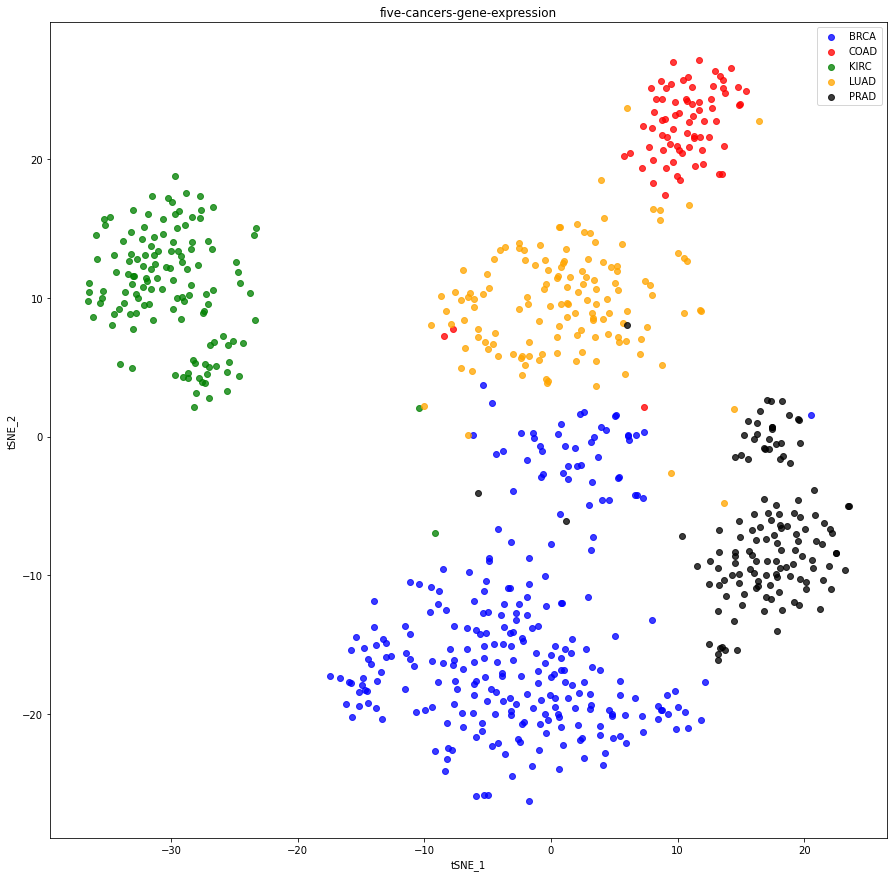

In [52]:
plt.figure(figsize=(15,15))
plt.title("five-cancers-gene-expression")
plt.scatter(X[labels == 'BRCA', 0], X[labels == 'BRCA', 1], c='b', label = "BRCA", alpha = 0.77)
plt.scatter(X[labels == 'COAD', 0], X[labels == 'COAD', 1], c='r', label = "COAD", alpha = 0.77)
plt.scatter(X[labels == 'KIRC', 0], X[labels == 'KIRC', 1], c='g', label = "KIRC", alpha = 0.77)
plt.scatter(X[labels == 'LUAD', 0], X[labels == 'LUAD', 1], c='orange', label = "LUAD", alpha = 0.77)
plt.scatter(X[labels == 'PRAD', 0], X[labels == 'PRAD', 1], c='black', label = "PRAD", alpha = 0.77)
plt.xlabel("tSNE_1")
plt.ylabel("tSNE_2")
plt.legend()
plt.show()

When I set the default parameters in the T-sne (number of components = 2), I noticed that T-sne classifies the cancer type in highly distinguishable cluster. However, I noticed that the green cancer type KIRC was perfectly separated from the rest of the cancer types (shown in the bottom left corner). However, the rest of the cancer types have some minor overlap with each other but they are also easily distinguisable.  

b. (8 points) Repeat the procedures in part a, with additional hyperparameter tuning based on guidelines below. Compared to part a above, do you see any differences?

• Number of components ncomponent = 2 (no change to this hyperparameter)

• Perplexity θ : 10 ≤ θ ≤ 60 (default: 30)

• Learning rate α : 50 ≤ α ≤ 500 (default: 200)

• You may tune other hyperparameters (e.g. number of iterations, weight initialization method) as you wish.

(Hint: There is not a definitive answer to this part. Please try your best to describe the observations that you see.)

In [53]:
# Low perplexity High learning rate
tsne = TSNE(n_components=2,
            perplexity = 10,
            learning_rate = 500,
            )
# tsne fit transform normalized gene expression data
X = tsne.fit_transform(data_geneX_values_norm2)

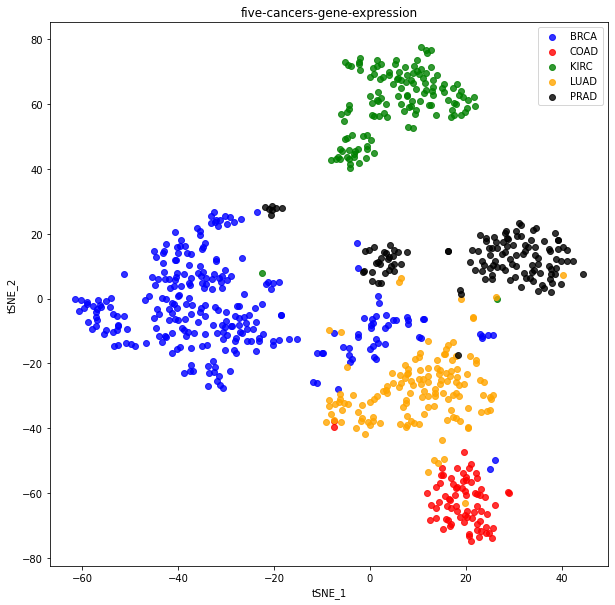

In [54]:
plt.figure(figsize=(10,10))
plt.title("five-cancers-gene-expression")
plt.scatter(X[labels == 'BRCA', 0], X[labels == 'BRCA', 1], c='b', label = "BRCA", alpha = 0.8)
plt.scatter(X[labels == 'COAD', 0], X[labels == 'COAD', 1], c='r', label = "COAD", alpha = 0.8)
plt.scatter(X[labels == 'KIRC', 0], X[labels == 'KIRC', 1], c='g', label = "KIRC", alpha = 0.8)
plt.scatter(X[labels == 'LUAD', 0], X[labels == 'LUAD', 1], c='orange', label = "LUAD", alpha = 0.8)
plt.scatter(X[labels == 'PRAD', 0], X[labels == 'PRAD', 1], c='black', label = "PRAD", alpha = 0.8)
plt.xlabel("tSNE_1")
plt.ylabel("tSNE_2")
plt.legend()
plt.show()

In [55]:
# High perplexity and Low learning rate
tsne = TSNE(n_components=2,
            perplexity = 50,
            learning_rate = 50,
            )
# tsne fit transform normalized gene expression data
X2 = tsne.fit_transform(data_geneX_values_norm2)

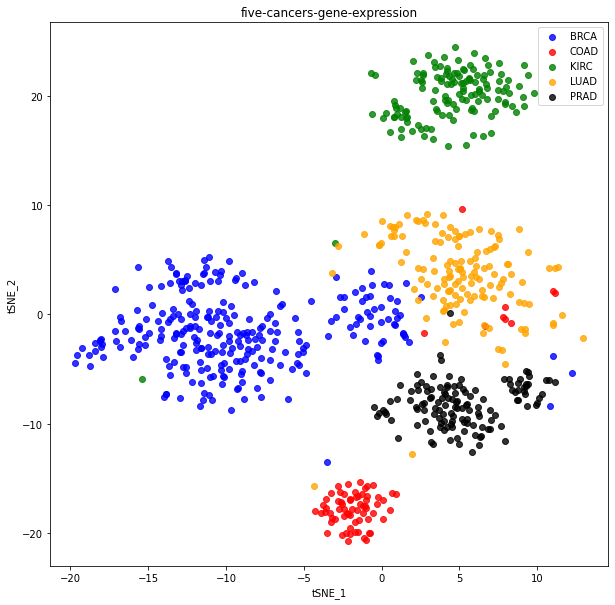

In [56]:
plt.figure(figsize=(10,10))
plt.title("five-cancers-gene-expression")
plt.scatter(X2[labels == 'BRCA', 0], X2[labels == 'BRCA', 1], c='b', label = "BRCA", alpha = 0.8)
plt.scatter(X2[labels == 'COAD', 0], X2[labels == 'COAD', 1], c='r', label = "COAD", alpha = 0.8)
plt.scatter(X2[labels == 'KIRC', 0], X2[labels == 'KIRC', 1], c='g', label = "KIRC", alpha = 0.8)
plt.scatter(X2[labels == 'LUAD', 0], X2[labels == 'LUAD', 1], c='orange', label = "LUAD", alpha = 0.8)
plt.scatter(X2[labels == 'PRAD', 0], X2[labels == 'PRAD', 1], c='black', label = "PRAD", alpha = 0.8)
plt.xlabel("tSNE_1")
plt.ylabel("tSNE_2")
plt.legend()
plt.show()

In [57]:
# High perplexity, High learning rate

tsne = TSNE(n_components=2,
            perplexity = 60,
            learning_rate = 500,
            )
# tsne fit transform normalized gene expression data
X3 = tsne.fit_transform(data_geneX_values_norm2)

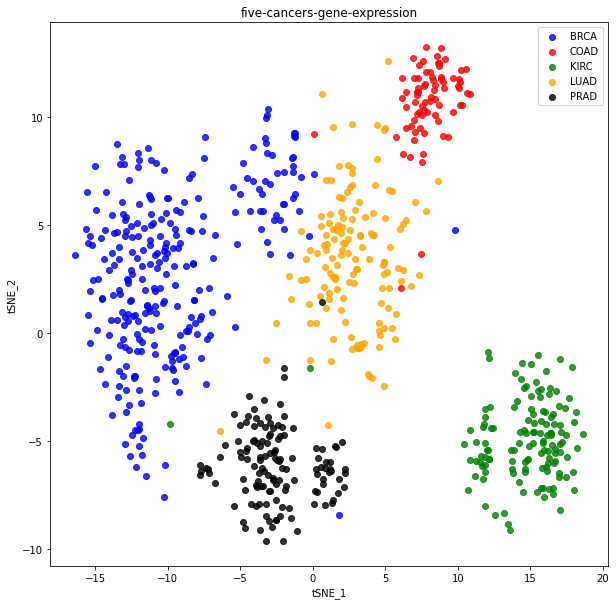

In [58]:
plt.figure(figsize=(10,10))
plt.title("five-cancers-gene-expression")
plt.scatter(X3[labels == 'BRCA', 0], X3[labels == 'BRCA', 1], c='b', label = "BRCA", alpha = 0.8)
plt.scatter(X3[labels == 'COAD', 0], X3[labels == 'COAD', 1], c='r', label = "COAD", alpha = 0.8)
plt.scatter(X3[labels == 'KIRC', 0], X3[labels == 'KIRC', 1], c='g', label = "KIRC", alpha = 0.8)
plt.scatter(X3[labels == 'LUAD', 0], X3[labels == 'LUAD', 1], c='orange', label = "LUAD", alpha = 0.8)
plt.scatter(X3[labels == 'PRAD', 0], X3[labels == 'PRAD', 1], c='black', label = "PRAD", alpha = 0.8)
plt.xlabel("tSNE_1")
plt.ylabel("tSNE_2")
plt.legend()
plt.show()

In [59]:
# Low perplexity, Low learning rate

tsne = TSNE(n_components=2,
            perplexity = 10,
            learning_rate = 50,
            )
# tsne fit transform normalized gene expression data
X4 = tsne.fit_transform(data_geneX_values_norm2)

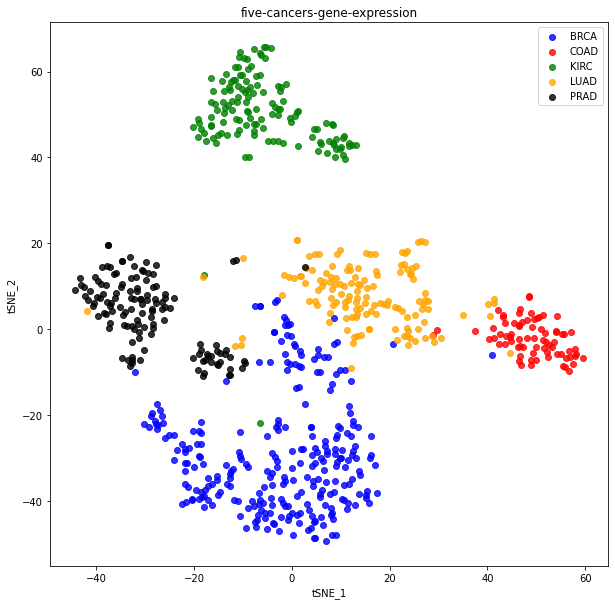

In [60]:
plt.figure(figsize=(10,10))
plt.title("five-cancers-gene-expression")
plt.scatter(X4[labels == 'BRCA', 0], X4[labels == 'BRCA', 1], c='b', label = "BRCA", alpha = 0.8)
plt.scatter(X4[labels == 'COAD', 0], X4[labels == 'COAD', 1], c='r', label = "COAD", alpha = 0.8)
plt.scatter(X4[labels == 'KIRC', 0], X4[labels == 'KIRC', 1], c='g', label = "KIRC", alpha = 0.8)
plt.scatter(X4[labels == 'LUAD', 0], X4[labels == 'LUAD', 1], c='orange', label = "LUAD", alpha = 0.8)
plt.scatter(X4[labels == 'PRAD', 0], X4[labels == 'PRAD', 1], c='black', label = "PRAD", alpha = 0.8)
plt.xlabel("tSNE_1")
plt.ylabel("tSNE_2")
plt.legend()
plt.show()

After running some trials and changing the perplexity and learning rate, I realized that the position of the clusters with regards to indentifying the different types of cancer changes. I realized that the smaller the learning rate, the more dense the points are and I see fewer outliers of the points with regards to classifying cancer. However, as the perplexity increases, the clusters of different cancer points get closer to one another.

c. (10 points) Now, apply UMAP on the same dataset. Here (https://umap-learn.readthedocs.io/en/latest/) is the instruction on how to install and use UMAP. There are several hyperparameters of UMAP, including n_neighbors, min_dist, n_components and metric. You are asked to fix n_components to be 2, and use "euclidean" as the metric. You need to explore a wide range of different choices of n_neighbors and min_dist, and choose the best combination of them based on your observation.

(Hint: There is not a definitive answer to this part.)

In [61]:
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors = 20, min_dist = 0.5)
embedding = reducer.fit_transform(geneseq.iloc[:,2:])
embedding.shape

(750, 2)

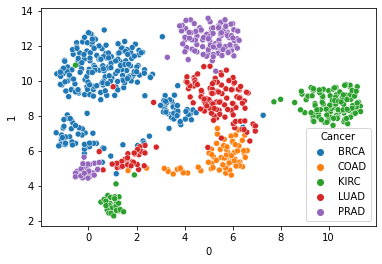

In [62]:
import seaborn as sns
data_umap = data_geneX_values_norm.join(pd.DataFrame(embedding))
data_umap
sns.scatterplot(0, 1, hue='Cancer', data=data_umap)

d. (6 points) Estimate the time it took to fit t-SNE and UMAP on simulated datasets. You can use any method to simulate a dataset. Vary the size of the simulated dataset with number of observations (n_obs) to be of {10,100,1000,10000}, and number of features (n_features) to be of {10,30,100,300}. You need to simulate a total of 4 × 4 = 16 datasets with every combination of n_obs and n_features. Record the time it takes (in seconds) to run t-SNE and UMAP on each of the dataset with the default parameters. Use a proper visualization method (e.g., a table or a figure) to show your results.

In [70]:
n_obs = [10, 100, 1000, 10000]
n_features = [10, 30, 100, 300]

datasets = {}

for o in n_obs:
  for f in n_features:
    name_str = str(o) + "_" + str(f)
    print(name_str)
    df_temp = np.random.rand(o, f)
    datasets[name_str] = df_temp

10_10
10_30
10_100
10_300
100_10
100_30
100_100
100_300
1000_10
1000_30
1000_100
1000_300
10000_10
10000_30
10000_100
10000_300


In [64]:
# T-SNE
import timeit
# from datetime import datetime

durations_tsne = {}
durations_umap = {}

for i,j in datasets.items():
  
  # T-SNE with default parameter
  start = timeit.default_timer()
  X_embedded = TSNE(n_components=2).fit_transform(j)
  stop = timeit.default_timer()
  durations_tsne[i] = stop - start

  # UMAP with default parameter
  start = timeit.default_timer()
  reducer = umap.UMAP(n_components=2, metric='euclidean')
  embedding = reducer.fit_transform(j)
  stop = timeit.default_timer()
  durations_umap[i] = stop - start

In [65]:
durations_tsne

{'10000_10': 86.69177148900008,
 '10000_100': 120.90168669699995,
 '10000_30': 90.62841532599998,
 '10000_300': 115.68240662200014,
 '1000_10': 7.327101918000039,
 '1000_100': 7.6285463259999915,
 '1000_30': 8.64887860600004,
 '1000_300': 7.365624937999996,
 '100_10': 0.5781361429999379,
 '100_100': 0.5813174160000472,
 '100_30': 0.5773253180000211,
 '100_300': 0.6081537860000026,
 '10_10': 0.17436741400001665,
 '10_100': 0.0926389939999126,
 '10_30': 0.1256675570000425,
 '10_300': 0.1493832260000545}

In [66]:
durations_umap

{'10000_10': 41.74351041500006,
 '10000_100': 24.874956078999958,
 '10000_30': 24.411534630999995,
 '10000_300': 26.030342725999844,
 '1000_10': 5.406021554999938,
 '1000_100': 5.552078116999951,
 '1000_30': 5.834228260999907,
 '1000_300': 5.938999174999935,
 '100_10': 3.146040149999976,
 '100_100': 3.140423687000066,
 '100_30': 3.5011658370000305,
 '100_300': 3.513051398000016,
 '10_10': 3.3273352120000936,
 '10_100': 3.3318435720000252,
 '10_30': 2.940302074999977,
 '10_300': 2.9572177600000487}

In [67]:
duration_tsne = pd.DataFrame({'no':[i+1 for i in range(16)], 
                              'name':list(durations_tsne.keys()), 
                              'tsne_training_duration_seconds':list(durations_tsne.values())})
duration_umap = pd.DataFrame({'no':[i+1 for i in range(16)], 
                              'name':list(durations_umap.keys()), 
                              'umap_training_duration_seconds':list(durations_umap.values())})

duration_umap

,no,name,umap_training_duration_seconds
0,1,10_10,3.327335
1,2,10_30,2.940302
2,3,10_100,3.331844
3,4,10_300,2.957218
4,5,100_10,3.146040
5,6,100_30,3.501166
6,7,100_100,3.140424
7,8,100_300,3.513051
8,9,1000_10,5.406022
9,10,1000_30,5.834228


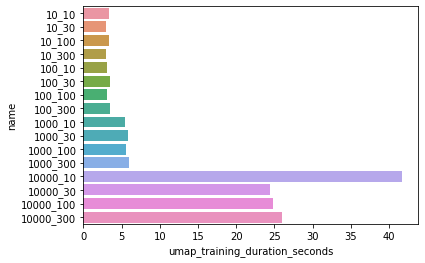

In [68]:
 
sns.barplot(x="umap_training_duration_seconds", y="name", data=duration_umap)

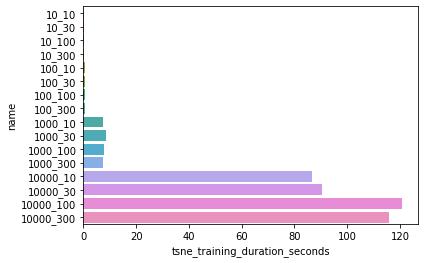

In [69]:
sns.barplot(x="tsne_training_duration_seconds", y="name", data=duration_tsne)